# 国土情報サービスなどの可視化
* 参考にしたページ
    * http://qiita.com/shima_x/items/fe29274d67de3a461524
    * http://sinhrks.hatenablog.com/entry/2015/06/14/215514
* 動作環境
    * anaconda3-4.0.0 を利用。他の anaconda のバージョンでも動作するはず。
    * gdal
      
      OSX の場合、OpenMP が標準の `gcc` に付属していないので、brew で入れる。
      ```
      brew install gdal  # version 1.11 when i installed it
      pip install gdal==1.11  # same as above
      ```
    *  その他のライブラリ
      ```
      pip install pyshp nkf
      pip install follium
      pip install seaborn  # Graph Visualization
      ```

## logger

In [8]:
from logging import getLogger, StreamHandler, INFO, NullHandler
logger = getLogger(__name__)
# handler = StreamHandler()
handler = NullHandler()
handler.setLevel(INFO)
logger.setLevel(INFO)
logger.addHandler(handler)

logger.debug('hello')

## shapefile to geojson
http://nlftp.mlit.go.jp/ksj/ から区画用の shapefile を取得しておく。
ここでは大分県の区画を利用している。

In [40]:
import os
import osgeo.ogr
import shapefile
import nkf
import json
from json import dumps

input_shape_file = "./N03-20150101_44_GML/N03-15_44_150101.shp"
intermediate_geojson_file = "./pyshp-oita-f02.json"

json 用に dict 型にする

In [41]:
shape_reader = shapefile.Reader(input_shape_file)

# extract field names
fields = shape_reader.fields[1:]
field_names = [field[0] for field in fields]

out_buffer = []
for sr in shape_reader.shapeRecords():
    atr = dict(zip(field_names, sr.record))
    geom = sr.shape.__geo_interface__
    out_buffer.append(dict(type="Feature",
                       geometry=geom, properties=atr))

フィールド名に日本語があると、shift_jis のバイナリ文字列として認識してまうので utf-8 に変換する。

In [42]:
for out_buffer_item in out_buffer:
    for prop_key, prop_val in out_buffer_item["properties"].items():
        logger.debug("key: {}, value: {}".format(prop_key, prop_val))        
        if type(prop_val) == bytes:
            logger.debug("str: {}".format(prop_val.decode('shift-jis')))
            out_buffer_item["properties"][prop_key] = prop_val.decode('shift-jis')
        if prop_key == "N03_007":
            logger.debug("Value of Key N03_007 change to {}".format("M{}".format(prop_val)))
            out_buffer_item["properties"][prop_key]= "M{}".format(prop_val)

json ファイルとして吐き出す

In [43]:
geojson_str = dumps({"type": "FeatureCollection",
                     "features": out_buffer},
                    sort_keys=True, ensure_ascii=False, indent=2)

with open(intermediate_geojson_file, "w") as fh:
    logger.debug("output type: {}".format(type(geojson_str)))
    fh.write(geojson_str)

## Visualization via folium

In [77]:
from IPython.display import HTML
import folium
import gdal
import urllib
import time
import pandas as pd
import numpy as np
import scipy as sp
from numba import jit
import seaborn
import matplotlib.pyplot as plt

%matplotlib inline

ipython notebook に HTML を吐き出す関数は follium 0.2 から不要になりました。

In [45]:
# # folium.initialize_notebook()  # is not available

# def inline_map(m, out_html_str='tmp.html'):
#     # thanks to http://sinhrks.hatenablog.com/entry/2015/06/14/215514
#     m.create_map(path='tmp.html')
#     iframe = '<iframe srcdoc=\"{srcdoc}\" style=\"width: 100%; height: 400px; border: none\"></iframe>'
#     return HTML(iframe.format(srcdoc=m.HTML.replace('\"', '&quot;')))

とりあえず folium で HTML を履いてみる

In [46]:
m = folium.Map(location=[33.2382026, 131.612535], zoom_start=8)
m.simple_marker([33.2382026, 131.612535], popup='Oita')

# This code is available at follium 0.1.x
# inline_map(m, "trial_oita.html")
m


/usr/local/opt/pyenv/versions/anaconda3-4.0.0/lib/python3.5/site-packages/ipykernel/__main__.py:2: FutureWarning: simple_marker is deprecated. Use add_children(Marker) instead
  from ipykernel import kernelapp as app


### 地図を用いた可視化用にデータをとってくる
http://www.land.mlit.go.jp/webland/download 当たりから大分県の不動産取引価格情報を取得

In [78]:
oita_webland_data_dir = "./webland_oita/"

### pandas で読み込む

フォルダ配下すべての csv を読み込んで結合する。
読み込むデータは不動産価格の取引情報（オープンデータ）

In [47]:
arr_df_webland_oita = []
# find csv files and append to array
for file in os.listdir(oita_webland_data_dir):
    if file.endswith(".csv"):
        df_tmp = pd.read_csv(oita_webland_data_dir+file,
                             encoding="cp932",
                             index_col=0)
        arr_df_webland_oita.append(df_tmp)

#  all dataframes
df_webland_oita = pd.concat(arr_df_webland_oita, ignore_index=True)

In [48]:
df_webland_oita.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4285 entries, 0 to 4284
Data columns (total 28 columns):
種類            4285 non-null object
地域            2609 non-null object
市区町村コード       4285 non-null int64
都道府県名         4285 non-null object
市区町村名         4285 non-null object
地区名           4260 non-null object
最寄駅：名称        2886 non-null object
最寄駅：距離（分）     2884 non-null object
取引価格（総額）      4285 non-null int64
坪単価           1582 non-null float64
間取り           268 non-null object
面積（㎡）         4285 non-null object
取引価格（㎡単価）     1582 non-null float64
土地の形状         2604 non-null object
間口            2241 non-null object
延床面積（㎡）       948 non-null object
建築年           1129 non-null object
建物の構造         1217 non-null object
建物の用途         1217 non-null object
今後の利用目的       439 non-null object
前面道路：方位       2609 non-null object
前面道路：種類       2515 non-null object
前面道路：幅員（ｍ）    2419 non-null float64
都市計画          2855 non-null object
建ぺい率（％）       2451 non-null float64
容積率（％）        2451 

In [25]:
df_webland_oita.head()

,種類,地域,市区町村コード,都道府県名,市区町村名,地区名,最寄駅：名称,最寄駅：距離（分）,取引価格（総額）,坪単価,...,建物の用途,今後の利用目的,前面道路：方位,前面道路：種類,前面道路：幅員（ｍ）,都市計画,建ぺい率（％）,容積率（％）,取引時点,備考
0,宅地(土地),工業地,44201,大分県,大分市,青崎,大在,30分～60分,30000000,62000.0,...,NaN,NaN,西,市道,16.0,準工業地域,60.0,200.0,平成25年第１四半期,NaN
1,宅地(土地と建物),工業地,44201,大分県,大分市,青崎,大在,30分～60分,35000000,NaN,...,倉庫,NaN,南,市道,8.0,準工業地域,60.0,200.0,平成25年第１四半期,NaN
2,農地,NaN,44201,大分県,大分市,大字丹川,NaN,NaN,1000000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,平成25年第１四半期,NaN
3,中古マンション等,NaN,44201,大分県,大分市,明野北,高城,30分～60分,9800000,NaN,...,住宅,NaN,NaN,NaN,NaN,第１種中高層住居専用地域,60.0,200.0,平成25年第１四半期,改装済を購入
4,中古マンション等,NaN,44201,大分県,大分市,明野北,高城,28,8400000,NaN,...,住宅,NaN,NaN,NaN,NaN,第１種中高層住居専用地域,60.0,200.0,平成25年第１四半期,未改装を購入


坪単価の列に何故か null 値があるので自分で計算する。

In [26]:
pd.value_counts(df_webland_oita["面積（㎡）"])

5000㎡以上    210
210        117
2000㎡以上    109
220        105
200        102
230        101
250         79
1100        74
240         73
270         65
300         63
1200        62
280         60
170         59
330         56
190         56
260         56
70          53
180         52
1000        52
165         51
360         49
195         48
290         48
1300        48
350         48
80          47
320         47
175         47
75          46
          ... 
710          9
3600         8
970          8
840          8
2700         8
930          8
780          7
3400         6
4200         6
950          6
910          6
4000         5
870          5
900          5
3700         5
4300         5
960          5
810          5
3800         5
4100         5
4700         5
3300         4
4400         4
4600         3
3900         3
4500         3
3200         2
4900         2
4800         2
15           1
Name: 面積（㎡）, dtype: int64

In [69]:
def calc_price_per_tsubo(price_arr_values, area_arr_values):
    assert len(price_arr_values) == len(area_arr_values)
    return_arr = np.zeros([len(price_arr_values), ], dtype=np.float64)
    for i in range(len(price_arr_values)):
        try:
            float_area = float(area_arr_values[i])
            float_price = float(price_arr_values[i])
            return_arr[i] = float_price / (float_area * 0.3025)
        except Exception as err:
#             logger.debug(err)
            return_arr[i] = np.nan
    return return_arr

In [70]:
df_webland_oita["price_per_tsubo"] = calc_price_per_tsubo(df_webland_oita["取引価格（総額）"].values,
                                                               df_webland_oita["面積（㎡）"].values)
df_webland_oita.describe()

,市区町村コード,取引価格（総額）,坪単価,取引価格（㎡単価）,前面道路：幅員（ｍ）,建ぺい率（％）,容積率（％）,price_per_tsubo
count,4285.000000,4.285000e+03,1582.000000,1582.000000,2419.000000,2451.000000,2451.000000,3.966000e+03
mean,44217.703617,1.240033e+07,97807.483565,29583.822377,6.868003,63.439412,221.664627,1.350673e+05
std,52.006009,4.280448e+07,89697.247046,27101.326648,4.785688,9.682843,91.241792,2.187002e+05
min,44201.000000,2.000000e+03,59.000000,18.000000,1.000000,30.000000,60.000000,1.180638e+01
25%,44201.000000,8.200000e+05,32000.000000,9550.000000,4.000000,60.000000,200.000000,4.314658e+03
50%,44204.000000,4.800000e+06,79000.000000,24000.000000,6.000000,60.000000,200.000000,6.019357e+04
75%,44210.000000,1.200000e+07,140000.000000,41000.000000,7.500000,70.000000,200.000000,1.731602e+05
max,44462.000000,1.100000e+09,820000.000000,250000.000000,40.000000,80.000000,600.000000,5.121639e+06


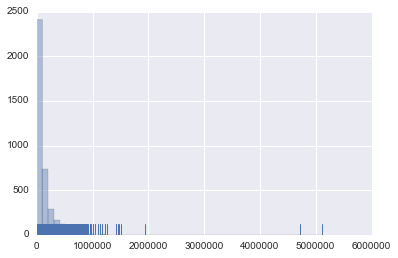

In [71]:
seaborn.distplot(df_webland_oita["price_per_tsubo"].dropna().values, kde=False, rug=True);

飛び抜けて高い値がいくつかあるので median で市町村コードで集計をかける

In [72]:
df_oita_median_by_city = df_webland_oita.groupby("市区町村コード").median()


folium 0.2.1 でのバグのため、キーとなる列を文字列にする。

In [76]:
df_oita_median_by_city["city_code"] = np.array(["M"+str(x) for x in df_oita_median_by_city.index.values])
df_oita_median_by_city.index = np.array(["M"+str(x) for x in df_oita_median_by_city.index.values])

In [74]:
df_oita_median_by_city

,取引価格（総額）,坪単価,取引価格（㎡単価）,前面道路：幅員（ｍ）,建ぺい率（％）,容積率（％）,price_per_tsubo,city_code
M44201,12000000,120000.0,35000.0,6.0,60.0,200.0,180546.726001,M44201
M44202,11000000,150000.0,45000.0,5.5,60.0,200.0,192336.589031,M44202
M44203,4000000,53000.0,16000.0,6.0,60.0,200.0,37780.401417,M44203
M44204,2250000,89000.0,27000.0,5.5,60.0,200.0,15112.160567,M44204
M44205,1000000,55000.0,17000.0,6.0,60.0,200.0,11019.283747,M44205
M44206,2050000,72500.0,22000.0,4.3,60.0,200.0,22038.567493,M44206
M44207,1400000,70000.0,21000.0,6.0,60.0,200.0,27838.190518,M44207
M44208,600000,42500.0,13000.0,6.0,70.0,200.0,2232.753472,M44208
M44209,765000,21500.0,6600.0,5.0,60.0,200.0,2880.040070,M44209
M44210,2000000,31000.0,9500.0,6.0,70.0,200.0,9015.777611,M44210


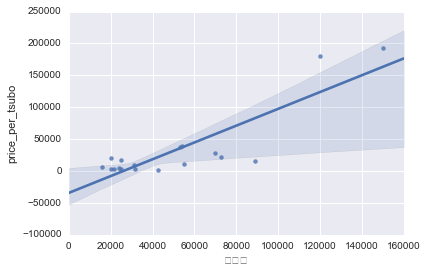

In [32]:
seaborn.regplot(x="坪単価", y="price_per_tsubo", data=df_oita_median_by_city)

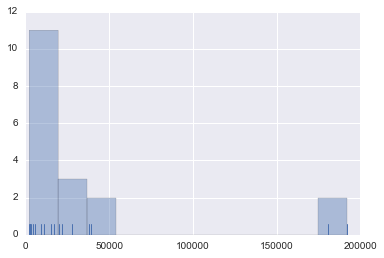

In [33]:
seaborn.distplot(df_oita_median_by_city["price_per_tsubo"].dropna().values, kde=False, rug=True);

### using dataframe and geojson visualization

In [79]:
# map作成
m = folium.Map(location=[33.2382026, 131.612535], zoom_start=8)

# m.geo_json(geo_path=intermediate_geojson_file, data=df_oita_median_by_city,  # folium 0.1.x
m.choropleth(geo_path=intermediate_geojson_file, data=df_oita_median_by_city,
    columns=['city_code', 'price_per_tsubo'],
    key_on='feature.properties.N03_007',
    threshold_scale=[5000, 10000, 25000, 40000, 150000],
    fill_color='BuPu', reset=True,
    legend_name='price_per_tsubo')

# code using my `inline_map()` is available at follium 0.1.x
# inline_map(m)

m

KeyError: 'M44201'